Implementation of DenseUnet to segment Retina Blood Vessels

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 12
buffer_size = 100
num_epochs = 300
lr = 1e-3
seed = 42
np.random.seed = seed

Loading the image and mask paths

In [4]:
train_path = 'Datasets/RETINA_MIXED/Retina_aug/Train/Image'
train_mask_path = 'Datasets/RETINA_MIXED/Retina_aug/Train/Mask'
test_path = 'Datasets/RETINA_MIXED/Retina_aug/Test/Image'
test_mask_path = 'Datasets/RETINA_MIXED/Retina_aug/Test/Mask'

X_train, Y_train = load_path(train_path, train_mask_path)
X_test, Y_test = load_path(test_path, test_mask_path)

Loading the image and masks to tensorflow dataset

In [5]:
Train = tf_data(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_data(X_test, Y_test, buffer_size, batch_size, num_epochs)

Displaying the train and test images and mask

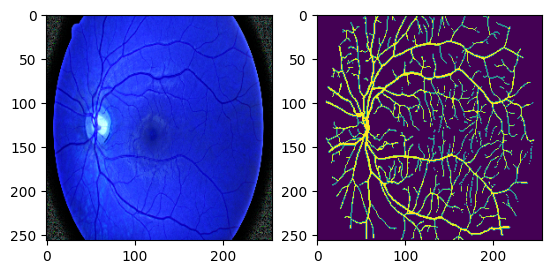

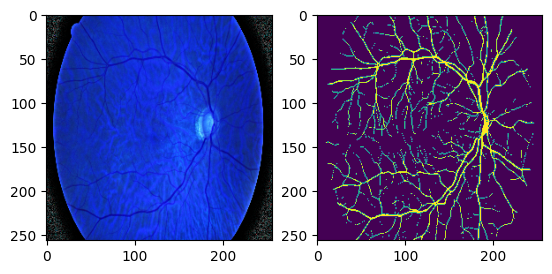

In [6]:
for x, y in Train:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();
    break
    
for x, y in Test:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();
    break

In [7]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [8]:
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121, InceptionResNetV2

In [9]:
def conv_block(inputs, num_filters, dropout = False):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if(dropout):
        x = Dropout(0.1)(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [10]:
def decoder_block(inputs, skip_features, num_filters, dropout = False):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout)
    return x

In [11]:
def build_densenet121_unet(input_shape):
    
    inputs = Input(input_shape)
    
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    b1 = densenet.get_layer("pool4_relu").output

    d1 = decoder_block(b1, s4, 256, True)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64, True)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [13]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

input_shape = (h, w, 3)
model = build_densenet121_unet(input_shape)
model.compile(optimizer = Adam(lr), loss = dice_loss, metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [16]:
model_path = os.path.join('InceptionResNetV2_U-Net.h5')
csv_path = os.path.join('InceptionResNetV2_U-Net.csv')

#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose = 1, save_best_only = True)

callbacks=[
    ModelCheckpoint(model_path, verbose = 1, save_best_only = True),
    tf.keras.callbacks.EarlyStopping(patience = 100, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs'),
    CSVLogger(csv_path),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = 30,
    callbacks = callbacks)

Epoch 1/30
73/73 [==============================] - ETA: 0s - loss: 0.0612 - dice_coef: 0.9388 - iou: 0.8851 - accuracy: 0.9889 - recall: 0.9181 - precision: 0.9575
Epoch 00001: val_loss improved from inf to 0.20329, saving model to InceptionResNetV2_U-Net.h5
73/73 [==============================] - 59s 802ms/step - loss: 0.0612 - dice_coef: 0.9388 - iou: 0.8851 - accuracy: 0.9889 - recall: 0.9181 - precision: 0.9575 - val_loss: 0.2033 - val_dice_coef: 0.7967 - val_iou: 0.6622 - val_accuracy: 0.9639 - val_recall: 0.7592 - val_precision: 0.8380
Epoch 2/30
73/73 [==============================] - ETA: 0s - loss: 0.0618 - dice_coef: 0.9382 - iou: 0.8842 - accuracy: 0.9888 - recall: 0.9177 - precision: 0.9572
Epoch 00002: val_loss improved from 0.20329 to 0.20275, saving model to InceptionResNetV2_U-Net.h5
73/73 [==============================] - 55s 754ms/step - loss: 0.0618 - dice_coef: 0.9382 - iou: 0.8842 - accuracy: 0.9888 - recall: 0.9177 - precision: 0.9572 - val_loss: 0.2028 - val_

Epoch 17/30
73/73 [==============================] - ETA: 0s - loss: 0.0592 - dice_coef: 0.9408 - iou: 0.8887 - accuracy: 0.9893 - recall: 0.9199 - precision: 0.9599
Epoch 00017: val_loss did not improve from 0.19947
73/73 [==============================] - 60s 822ms/step - loss: 0.0592 - dice_coef: 0.9408 - iou: 0.8887 - accuracy: 0.9893 - recall: 0.9199 - precision: 0.9599 - val_loss: 0.1998 - val_dice_coef: 0.8002 - val_iou: 0.6671 - val_accuracy: 0.9636 - val_recall: 0.7809 - val_precision: 0.8203
Epoch 18/30
73/73 [==============================] - ETA: 0s - loss: 0.0599 - dice_coef: 0.9401 - iou: 0.8874 - accuracy: 0.9891 - recall: 0.9200 - precision: 0.9585
Epoch 00018: val_loss did not improve from 0.19947
73/73 [==============================] - 57s 776ms/step - loss: 0.0599 - dice_coef: 0.9401 - iou: 0.8874 - accuracy: 0.9891 - recall: 0.9200 - precision: 0.9585 - val_loss: 0.2041 - val_dice_coef: 0.7959 - val_iou: 0.6611 - val_accuracy: 0.9640 - val_recall: 0.7535 - val_prec

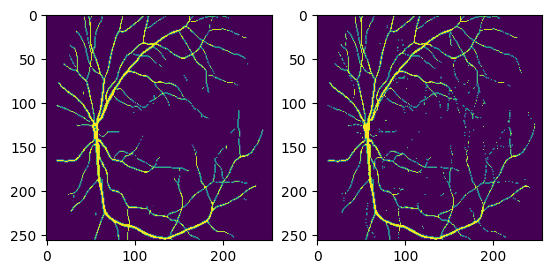

In [17]:
x, y = get_np_images(X_train, Y_train)
y_pred = model.predict(np.expand_dims(x[0], axis = 0))
# y_pred = y_pred > 0.5
# y_pred = y_pred.astype(np.int32)
f, plot = plt.subplots(1,2)
plot[0].imshow(y_pred[0])
plot[1].imshow(y[0])
plt.show();

In [19]:
model.save('densenet121_unet.h5')